In [1]:
import os
import numpy as np
import torch
import pyedflib
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn as nn
import torch.nn.functional as F
from scipy.fft import fft
from collections import Counter

# 설정
sampling_rate = 256
segment_length = 30 * sampling_rate
fft_length = segment_length // 2
label_map = {
    'Sleep stage W': 0,
    'Sleep stage N1': 1,
    'Sleep stage N2': 1,
    'Sleep stage N3': 2,
    'Sleep stage R': 3
}
root_dir = "/home/mhb0917/캡스톤디자인/sleep/recordings"

In [2]:
from scipy.signal import stft

def segment_and_stft(signal):
    segments = []
    for start in range(0, len(signal) - segment_length, segment_length):
        segment = signal[start:start+segment_length]
        _, _, Zxx = stft(segment, fs=sampling_rate, nperseg=256)
        spectrogram = np.abs(Zxx)  # shape: (freq, time)
        segments.append(spectrogram)
    return np.array(segments)


In [3]:
def load_data_from_sn(sn_list):
    all_segments = []
    all_labels = []
    for sn in sn_list:
        base = f"SN{sn:03d}"
        ecg_path = os.path.join(root_dir, f"{base}.edf")
        label_path = os.path.join(root_dir, f"{base}_sleepscoring.edf")
        if not os.path.exists(ecg_path) or not os.path.exists(label_path):
            print(f"❌ 파일 없음: {base}")
            continue
        try:
            ecg_reader = pyedflib.EdfReader(ecg_path)
            ecg_signal = ecg_reader.readSignal(7)
        finally:
            ecg_reader._close()
        try:
            label_reader = pyedflib.EdfReader(label_path)
            annotations = label_reader.readAnnotations()
        finally:
            label_reader._close()
        onsets, durations, labels = annotations
        label_seq = []
        for i in range(len(labels)):
            label_str = labels[i].decode() if isinstance(labels[i], bytes) else labels[i]
            if label_str in label_map:
                label_index = label_map[label_str]
                num_segments = int(durations[i] // 30)
                label_seq.extend([label_index] * num_segments)
        stft_segments = segment_and_stft(ecg_signal)
        max_segments = len(stft_segments)
        usable_len = min(len(label_seq), max_segments)
        all_segments.extend(stft_segments[:usable_len])
        all_labels.extend(label_seq[:usable_len])
    X = torch.tensor(np.expand_dims(np.array(all_segments), axis=1), dtype=torch.float32)
    y = torch.tensor(all_labels, dtype=torch.long)
    return X, y

In [4]:
def load_balanced_data_from_sn(sn_list):
    all_segments = []
    all_labels = []
    for sn in sn_list:
        try:
            X, y = load_data_from_sn([sn])
        except Exception as e:
            print(f"❌ SN{sn:03d} 불러오기 실패: {e}")
            continue
        if len(y) == 0:
            print(f"⚠️ SN{sn:03d}: 라벨 없음 → 건너뜀")
            continue
        y_np = y.numpy()
        X_np = X.numpy()
        label_counts = Counter(y_np)
        if len(label_counts) < 2:
            print(f"⚠️ SN{sn:03d}: 라벨 다양성 부족 → 건너뜀")
            continue
        min_count = min(label_counts.values())
        indices = []
        for label in sorted(label_counts.keys()):
            label_indices = np.where(y_np == label)[0]
            if len(label_indices) < min_count:
                continue
            sampled = np.random.choice(label_indices, min_count, replace=False)
            indices.extend(sampled)
        if not indices:
            print(f"⚠️ SN{sn:03d}: 유효한 샘플 없음 → 건너뜀")
            continue
        np.random.shuffle(indices)
        all_segments.append(X_np[indices])
        all_labels.append(y_np[indices])
        print(f"✅ SN{sn:03d} 처리 완료: 클래스당 {min_count}개")
    if not all_segments:
        raise ValueError("⚠️ 유효한 데이터가 없습니다. SN 목록을 다시 확인하세요.")
    X_all = torch.tensor(np.concatenate(all_segments), dtype=torch.float32)
    y_all = torch.tensor(np.concatenate(all_labels), dtype=torch.long)
    return X_all, y_all

In [5]:
X_train, y_train = load_balanced_data_from_sn(list(range(1, 94)))
X_val, y_val = load_balanced_data_from_sn(list(range(94, 124)))
X_test, y_test = load_data_from_sn(list(range(124, 154)))

✅ SN001 처리 완료: 클래스당 23개


✅ SN002 처리 완료: 클래스당 82개


✅ SN003 처리 완료: 클래스당 150개


✅ SN004 처리 완료: 클래스당 64개


✅ SN005 처리 완료: 클래스당 127개


✅ SN006 처리 완료: 클래스당 65개


✅ SN007 처리 완료: 클래스당 67개


✅ SN008 처리 완료: 클래스당 39개


✅ SN009 처리 완료: 클래스당 91개


✅ SN010 처리 완료: 클래스당 101개


✅ SN011 처리 완료: 클래스당 37개


✅ SN012 처리 완료: 클래스당 184개


✅ SN013 처리 완료: 클래스당 65개
❌ 파일 없음: SN014
⚠️ SN014: 라벨 없음 → 건너뜀


✅ SN015 처리 완료: 클래스당 102개


✅ SN016 처리 완료: 클래스당 24개


✅ SN017 처리 완료: 클래스당 96개


✅ SN018 처리 완료: 클래스당 19개


✅ SN019 처리 완료: 클래스당 72개


✅ SN020 처리 완료: 클래스당 67개


✅ SN021 처리 완료: 클래스당 156개


✅ SN022 처리 완료: 클래스당 115개


✅ SN023 처리 완료: 클래스당 74개


✅ SN024 처리 완료: 클래스당 70개


✅ SN025 처리 완료: 클래스당 106개


✅ SN026 처리 완료: 클래스당 127개


✅ SN027 처리 완료: 클래스당 19개


✅ SN028 처리 완료: 클래스당 136개


✅ SN029 처리 완료: 클래스당 59개


✅ SN030 처리 완료: 클래스당 108개


✅ SN031 처리 완료: 클래스당 74개


✅ SN032 처리 완료: 클래스당 133개


✅ SN033 처리 완료: 클래스당 47개


✅ SN034 처리 완료: 클래스당 75개


✅ SN035 처리 완료: 클래스당 108개


✅ SN036 처리 완료: 클래스당 87개


✅ SN037 처리 완료: 클래스당 65개


✅ SN038 처리 완료: 클래스당 61개


✅ SN039 처리 완료: 클래스당 108개


✅ SN040 처리 완료: 클래스당 62개


✅ SN041 처리 완료: 클래스당 130개


✅ SN042 처리 완료: 클래스당 148개


✅ SN043 처리 완료: 클래스당 56개


✅ SN044 처리 완료: 클래스당 55개


✅ SN045 처리 완료: 클래스당 129개


✅ SN046 처리 완료: 클래스당 49개


✅ SN047 처리 완료: 클래스당 125개


✅ SN048 처리 완료: 클래스당 146개


✅ SN049 처리 완료: 클래스당 41개


✅ SN050 처리 완료: 클래스당 25개


✅ SN051 처리 완료: 클래스당 84개


✅ SN052 처리 완료: 클래스당 59개


✅ SN053 처리 완료: 클래스당 163개


✅ SN054 처리 완료: 클래스당 28개


✅ SN055 처리 완료: 클래스당 115개


✅ SN056 처리 완료: 클래스당 64개


✅ SN057 처리 완료: 클래스당 7개


✅ SN058 처리 완료: 클래스당 103개


✅ SN059 처리 완료: 클래스당 138개


✅ SN060 처리 완료: 클래스당 46개


✅ SN061 처리 완료: 클래스당 150개


✅ SN062 처리 완료: 클래스당 5개


✅ SN063 처리 완료: 클래스당 139개
❌ 파일 없음: SN064
⚠️ SN064: 라벨 없음 → 건너뜀


✅ SN065 처리 완료: 클래스당 65개


✅ SN066 처리 완료: 클래스당 88개


✅ SN067 처리 완료: 클래스당 123개


✅ SN068 처리 완료: 클래스당 116개


✅ SN069 처리 완료: 클래스당 69개


✅ SN070 처리 완료: 클래스당 35개


✅ SN071 처리 완료: 클래스당 16개


✅ SN072 처리 완료: 클래스당 115개


✅ SN073 처리 완료: 클래스당 39개


✅ SN074 처리 완료: 클래스당 37개


✅ SN075 처리 완료: 클래스당 186개


✅ SN076 처리 완료: 클래스당 56개


✅ SN077 처리 완료: 클래스당 85개


✅ SN078 처리 완료: 클래스당 55개


✅ SN079 처리 완료: 클래스당 61개


✅ SN080 처리 완료: 클래스당 28개


✅ SN081 처리 완료: 클래스당 2개


✅ SN082 처리 완료: 클래스당 37개


✅ SN083 처리 완료: 클래스당 136개


✅ SN084 처리 완료: 클래스당 27개


✅ SN085 처리 완료: 클래스당 111개


✅ SN086 처리 완료: 클래스당 110개


✅ SN087 처리 완료: 클래스당 34개


✅ SN088 처리 완료: 클래스당 125개


✅ SN089 처리 완료: 클래스당 85개


✅ SN090 처리 완료: 클래스당 76개


✅ SN091 처리 완료: 클래스당 40개


✅ SN092 처리 완료: 클래스당 93개


✅ SN093 처리 완료: 클래스당 71개


✅ SN094 처리 완료: 클래스당 79개


✅ SN095 처리 완료: 클래스당 50개


✅ SN096 처리 완료: 클래스당 55개


✅ SN097 처리 완료: 클래스당 46개


✅ SN098 처리 완료: 클래스당 80개


✅ SN099 처리 완료: 클래스당 56개


✅ SN100 처리 완료: 클래스당 81개


✅ SN101 처리 완료: 클래스당 120개


✅ SN102 처리 완료: 클래스당 36개


✅ SN103 처리 완료: 클래스당 70개


✅ SN104 처리 완료: 클래스당 104개


✅ SN105 처리 완료: 클래스당 34개


✅ SN106 처리 완료: 클래스당 53개


✅ SN107 처리 완료: 클래스당 77개


✅ SN108 처리 완료: 클래스당 50개


✅ SN109 처리 완료: 클래스당 48개


✅ SN110 처리 완료: 클래스당 96개


✅ SN111 처리 완료: 클래스당 135개


✅ SN112 처리 완료: 클래스당 83개


✅ SN113 처리 완료: 클래스당 85개


✅ SN114 처리 완료: 클래스당 73개


✅ SN115 처리 완료: 클래스당 98개


✅ SN116 처리 완료: 클래스당 43개


✅ SN117 처리 완료: 클래스당 108개


✅ SN118 처리 완료: 클래스당 114개


✅ SN119 처리 완료: 클래스당 89개


✅ SN120 처리 완료: 클래스당 29개


✅ SN121 처리 완료: 클래스당 61개


✅ SN122 처리 완료: 클래스당 66개


✅ SN123 처리 완료: 클래스당 98개


❌ 파일 없음: SN135


In [6]:
class ECGSleepCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(ECGSleepCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d((2, 2))

        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d((2, 2))

        self.flatten_size = 64 * (129 // 8) * (61 // 8)  # 풀링 3회 후 크기 추정
        self.fc1 = nn.Linear(self.flatten_size, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)


In [7]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECGSleepCNN(num_classes=4).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

for epoch in range(50):
    model.train()
    loss_sum, correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        loss = criterion(outputs, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        _, pred = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (pred == yb).sum().item()
    train_acc = 100 * correct / total
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            val_total += yb.size(0)
            val_correct += (pred == yb).sum().item()
    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    print(f"📘 Epoch {epoch+1} | Train Loss: {loss_sum:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")



📘 Epoch 1 | Train Loss: 1212.2064 | Train Acc: 33.75% | Val Loss: 1.6099 | Val Acc: 35.82%


📘 Epoch 2 | Train Loss: 1178.5280 | Train Acc: 36.68% | Val Loss: 1.5571 | Val Acc: 36.79%


📘 Epoch 3 | Train Loss: 1166.2248 | Train Acc: 37.84% | Val Loss: 1.4748 | Val Acc: 34.73%


📘 Epoch 4 | Train Loss: 1155.4465 | Train Acc: 38.83% | Val Loss: 1.5187 | Val Acc: 36.27%


📘 Epoch 5 | Train Loss: 1145.0895 | Train Acc: 39.32% | Val Loss: 1.4376 | Val Acc: 37.53%


📘 Epoch 6 | Train Loss: 1137.4734 | Train Acc: 40.67% | Val Loss: 1.4240 | Val Acc: 37.71%


📘 Epoch 7 | Train Loss: 1128.4960 | Train Acc: 41.69% | Val Loss: 1.4407 | Val Acc: 38.13%


📘 Epoch 8 | Train Loss: 1119.8852 | Train Acc: 41.99% | Val Loss: 1.3968 | Val Acc: 35.98%


📘 Epoch 9 | Train Loss: 1111.0190 | Train Acc: 42.67% | Val Loss: 1.4384 | Val Acc: 37.84%


📘 Epoch 10 | Train Loss: 1102.7991 | Train Acc: 43.06% | Val Loss: 1.4338 | Val Acc: 37.93%


📘 Epoch 11 | Train Loss: 1097.0819 | Train Acc: 43.96% | Val Loss: 1.4443 | Val Acc: 37.12%


📘 Epoch 12 | Train Loss: 1091.2797 | Train Acc: 44.61% | Val Loss: 1.4581 | Val Acc: 37.29%


📘 Epoch 13 | Train Loss: 1082.3925 | Train Acc: 45.48% | Val Loss: 1.4379 | Val Acc: 37.51%


📘 Epoch 14 | Train Loss: 1073.4713 | Train Acc: 46.05% | Val Loss: 1.4066 | Val Acc: 36.89%


📘 Epoch 15 | Train Loss: 1067.4732 | Train Acc: 46.80% | Val Loss: 1.4122 | Val Acc: 37.61%


📘 Epoch 16 | Train Loss: 1058.7479 | Train Acc: 47.50% | Val Loss: 1.4426 | Val Acc: 37.29%


📘 Epoch 17 | Train Loss: 1052.9077 | Train Acc: 47.91% | Val Loss: 1.4253 | Val Acc: 37.34%


📘 Epoch 18 | Train Loss: 1044.5595 | Train Acc: 48.64% | Val Loss: 1.4023 | Val Acc: 37.29%


📘 Epoch 19 | Train Loss: 1040.2295 | Train Acc: 49.14% | Val Loss: 1.3969 | Val Acc: 37.84%


📘 Epoch 20 | Train Loss: 1030.9174 | Train Acc: 49.93% | Val Loss: 1.4510 | Val Acc: 38.29%


📘 Epoch 21 | Train Loss: 1024.7005 | Train Acc: 50.00% | Val Loss: 1.4889 | Val Acc: 37.80%


📘 Epoch 22 | Train Loss: 1017.1828 | Train Acc: 50.97% | Val Loss: 1.4749 | Val Acc: 37.28%


📘 Epoch 23 | Train Loss: 1011.7061 | Train Acc: 50.89% | Val Loss: 1.4371 | Val Acc: 38.05%


📘 Epoch 24 | Train Loss: 1002.9663 | Train Acc: 51.36% | Val Loss: 1.5099 | Val Acc: 38.10%


📘 Epoch 25 | Train Loss: 995.3789 | Train Acc: 52.13% | Val Loss: 1.4412 | Val Acc: 38.38%


📘 Epoch 26 | Train Loss: 987.8388 | Train Acc: 52.70% | Val Loss: 1.5614 | Val Acc: 38.13%


📘 Epoch 27 | Train Loss: 980.7008 | Train Acc: 53.48% | Val Loss: 1.4663 | Val Acc: 39.08%


📘 Epoch 28 | Train Loss: 974.1394 | Train Acc: 53.88% | Val Loss: 1.4757 | Val Acc: 38.32%


📘 Epoch 29 | Train Loss: 965.6417 | Train Acc: 54.32% | Val Loss: 1.4903 | Val Acc: 37.96%


📘 Epoch 30 | Train Loss: 960.8666 | Train Acc: 54.87% | Val Loss: 1.4988 | Val Acc: 38.14%


📘 Epoch 31 | Train Loss: 956.9229 | Train Acc: 54.58% | Val Loss: 1.5596 | Val Acc: 39.12%


📘 Epoch 32 | Train Loss: 945.0409 | Train Acc: 55.55% | Val Loss: 1.5464 | Val Acc: 39.17%


📘 Epoch 33 | Train Loss: 937.9872 | Train Acc: 55.97% | Val Loss: 1.5460 | Val Acc: 38.69%


📘 Epoch 34 | Train Loss: 932.9175 | Train Acc: 56.52% | Val Loss: 1.5466 | Val Acc: 38.01%


📘 Epoch 35 | Train Loss: 924.3058 | Train Acc: 56.79% | Val Loss: 1.5026 | Val Acc: 38.34%


📘 Epoch 36 | Train Loss: 920.5118 | Train Acc: 56.98% | Val Loss: 1.4862 | Val Acc: 37.18%


📘 Epoch 37 | Train Loss: 910.2232 | Train Acc: 57.97% | Val Loss: 1.5364 | Val Acc: 36.27%


📘 Epoch 38 | Train Loss: 907.3109 | Train Acc: 58.09% | Val Loss: 1.6586 | Val Acc: 38.99%


📘 Epoch 39 | Train Loss: 898.5690 | Train Acc: 58.50% | Val Loss: 1.7376 | Val Acc: 38.86%


📘 Epoch 40 | Train Loss: 893.4394 | Train Acc: 58.82% | Val Loss: 1.5824 | Val Acc: 38.76%


📘 Epoch 41 | Train Loss: 887.9383 | Train Acc: 59.10% | Val Loss: 1.5864 | Val Acc: 39.00%


📘 Epoch 42 | Train Loss: 882.0649 | Train Acc: 59.25% | Val Loss: 1.6000 | Val Acc: 38.41%


📘 Epoch 43 | Train Loss: 872.7781 | Train Acc: 59.84% | Val Loss: 1.5158 | Val Acc: 38.60%


📘 Epoch 44 | Train Loss: 865.4145 | Train Acc: 60.36% | Val Loss: 1.7288 | Val Acc: 38.38%


📘 Epoch 45 | Train Loss: 858.5540 | Train Acc: 60.62% | Val Loss: 1.5932 | Val Acc: 38.21%


📘 Epoch 46 | Train Loss: 853.7833 | Train Acc: 60.94% | Val Loss: 1.5976 | Val Acc: 38.33%


📘 Epoch 47 | Train Loss: 847.4998 | Train Acc: 61.68% | Val Loss: 1.7006 | Val Acc: 37.63%


📘 Epoch 48 | Train Loss: 840.1201 | Train Acc: 61.92% | Val Loss: 1.6864 | Val Acc: 38.32%


📘 Epoch 49 | Train Loss: 836.8870 | Train Acc: 62.19% | Val Loss: 1.6140 | Val Acc: 38.44%


📘 Epoch 50 | Train Loss: 830.9511 | Train Acc: 62.29% | Val Loss: 1.7809 | Val Acc: 38.73%


In [8]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for i in range(0, len(X_test), 32):
        xb = X_test[i:i+32].to(device)
        yb = y_test[i:i+32].to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())


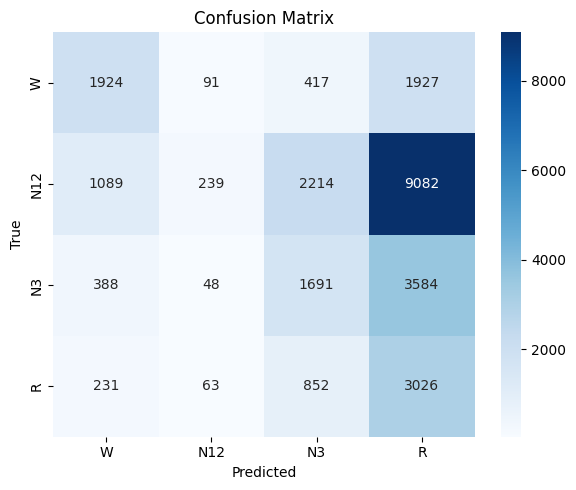

📄 Classification Report:
              precision    recall  f1-score   support

           W       0.53      0.44      0.48      4359
         N12       0.54      0.02      0.04     12624
          N3       0.33      0.30      0.31      5711
           R       0.17      0.73      0.28      4172

    accuracy                           0.26     26866
   macro avg       0.39      0.37      0.28     26866
weighted avg       0.44      0.26      0.20     26866



In [9]:
labels = ['W', 'N12', 'N3', 'R']
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
print("📄 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=labels))
